In [2]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/opt/anaconda/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
#the number of topics used in our topic model 
N_TOPICS = 30

#path to our storm file and 
STORMS_PATH  = "/shared/3/projects/newsDiffusion/data/processed/stormDfs/20000_90_storms.tsv"
ARTICLES_PATH = "/shared/3/projects/newsDiffusion/data/processed/fullDataWith20000.tsv"

stormsDf = pd.read_csv(STORMS_PATH, sep="\t")
artDf = pd.read_csv(ARTICLES_PATH, sep="\t")

artDf = artDf.drop(columns=["Unnamed: 0"])
stormsDf = stormsDf.drop(columns=["Unnamed: 0"])

<ipython-input-3-1754945692c3>:9: DtypeWarning: Columns (4,5,12,13,15,16,19) have mixed types. Specify dtype option on import or set low_memory=False.
  artDf = pd.read_csv(ARTICLES_PATH, sep="\t")


In [4]:
#set up colors
tab10 = sns.color_palette("tab10")

colNames = ["blue", "orange", "green", "red", "purple", "brown", "pink", "grey", "yellow", "turqoise"]
colDict = dict(zip(colNames, tab10))

In [5]:
#the name of the column with story-cluster labels adding _storm is the storm-cluster labels 
SCOL = "20000_90"
stormsDf[SCOL + "_storm"] = True

#merge storms information into our dataframe 
merged = pd.merge(artDf, stormsDf.drop(columns=[SCOL]), on="key", how="left")

#important: remove any dates before our first local date 
merged = merged[merged["date"] >= "2020-04-01"]


In [6]:
#load in our topics 
cols = ["dummy", "key"] + list(range(0, N_TOPICS))
docTopics = pd.read_csv("/shared/3/projects/newsDiffusion/data/interim/topicModelling/30/doc_topics.txt", sep="\t", names=cols)

#load in the words associated with topics 
topicWords = pd.read_csv("/shared/3/projects/newsDiffusion/data/interim/topicModelling/30/topic_keys.txt", sep="\t", \
                         names=["topicNum", "dummy", "words"], usecols=["topicNum", "words"])

#merge topics into dataframe 
merged = pd.merge(merged, docTopics.drop(columns=["dummy"]), on="key", how="left")

In [7]:
#quick check - largest storms have around 1000 articles 
stormSizes = merged.loc[merged[SCOL + "_storm"] == True, [SCOL, "key"]].groupby(SCOL).agg(len)

In [8]:
def getMax(inRow): 
    maxT = None 
    maxVal = 0
    for i in range(0, len(inRow)): 
        currVal = inRow[i]
        if currVal >= maxVal: 
            maxVal = currVal 
            maxT = i 
    return maxT

In [9]:
#get only rows associated with storms 
stormRows = merged.loc[merged[SCOL + "_storm"] == True]

#get the topic with the max proportion for each article, count up topics across all articles  
stormTopics = pd.DataFrame(stormRows[list(range(0, N_TOPICS))]).idxmax(axis=1).value_counts().reset_index().rename(columns={"index":"topicNum", "count":"topicAmt"})
stormTopics["topicNum"] = stormTopics["topicNum"].astype(int)

#merge the words associated with topics into our data 
stormTopics  = pd.merge(stormTopics , topicWords, on="topicNum")
stormTopics ["firstWords"] = stormTopics ["words"].apply(lambda x: ",".join(x.split()[:3]))

#change to percentage 
stormTopics["amtNormed"] = (stormTopics["topicAmt"] / sum(stormTopics["topicAmt"]))* 100
stormTopics  = stormTopics.sort_values("amtNormed", ascending=False)

In [10]:
#what our dataframe now looks like 
stormTopics.head()

,topicNum,topicAmt,words,firstWords,amtNormed
0,11,2796,court case law judge attorney justice federal ...,"court,case,law",13.752398
1,6,2492,police officers man officer city people black ...,"police,officers,man",12.257144
2,1,2408,bill state house senate democrats federal law ...,"bill,state,house",11.843982
3,3,2218,election state voters vote party voting republ...,"election,state,voters",10.909449
4,19,1967,trump president house capitol committee u.s fb...,"trump,president,house",9.674881


In [11]:
#get only rows NOT associated with storms 
nonStormRows = merged.loc[merged[SCOL + "_storm"] != True]

#nonStormTopics = pd.DataFrame(nonStormRows[list(range(0, N_TOPICS))].dropna().apply(sum)).reset_index().rename(columns={"index":"topicNum", 0:"topicAmt"})
nonStormTopics = pd.DataFrame(nonStormRows[list(range(0, N_TOPICS))]).idxmax(axis=1).value_counts().reset_index().rename(columns={"index":"topicNum", "count":"topicAmt"})
nonStormTopics["topicNum"] = nonStormTopics["topicNum"].astype(int)

nonStormTopics  = pd.merge(nonStormTopics, topicWords, on="topicNum")
nonStormTopics["firstWords"] = nonStormTopics["words"].apply(lambda x: ",".join(x.split()[:3]))

nonStormTopics["amtNormed"] = (nonStormTopics["topicAmt"] / sum(nonStormTopics["topicAmt"])) * 100
nonStormTopics  = nonStormTopics.sort_values("amtNormed", ascending=False)

In [12]:
#sanity check: sum(nonStormTopics["amtNormed"])

In [13]:
#figure stuff
FIG_PATH = "/home/blitt/projects/localNews/reports/figures/drafts/"
PALETTE = [ "#008837", "#7b3294"]

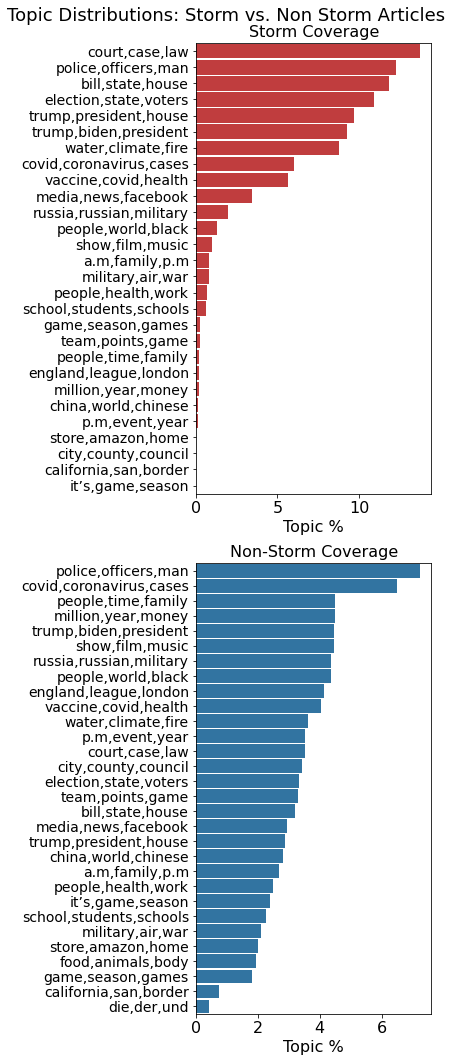

In [56]:
fig, axs = plt.subplots(2, figsize=(6, 15))
sns.barplot(x="amtNormed", y="firstWords",data=stormTopics, ax=axs[0], palette = [colDict["red"]], width=.9)
sns.barplot(x="amtNormed", y="firstWords",data=nonStormTopics, ax=axs[1], palette = [colDict["blue"]], width=.9)

plt.suptitle("Topic Distributions: Storm vs. Non Storm Articles", fontsize=18)
axs[0].set_title("Storm Coverage", fontsize=16)
axs[1].set_title("Non-Storm Coverage", fontsize=16)
axs[0].set_ylabel(None)
axs[1].set_ylabel(None)

#axs[0].set_yticklabels(axs[0].get_yticklabels(), fontsize=14)
#axs[1].set_yticklabels(axs[1].get_yticklabels(), fontsize=14)
axs[0].tick_params(axis='y', which='major', labelsize=14)
axs[1].tick_params(axis='y', which='major', labelsize=14)

#axs[0].set_xticklabels(axs[0].get_xticklabels(), fontsize=16)
#axs[1].set_xticklabels(axs[1].get_xticklabels(), fontsize=16)
axs[0].tick_params(axis='x', which='major', labelsize=16)
axs[1].tick_params(axis='x', which='major', labelsize=16)

axs[0].set_xlabel("Topic %", fontsize=16)
axs[1].set_xlabel("Topic %", fontsize=16)

plt.tight_layout()
plt.savefig(FIG_PATH + "stormTopicDists.pdf", bbox_inches = "tight")
#plt.tight_layout()


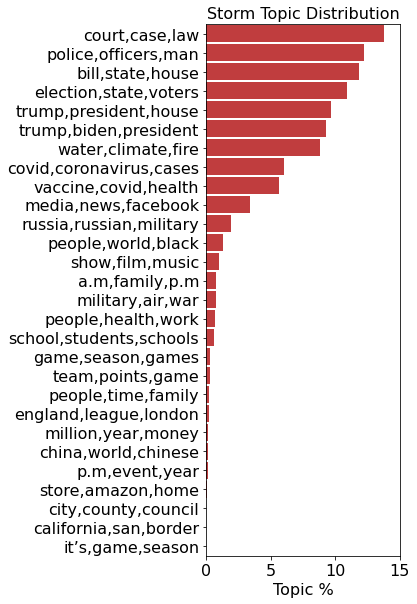

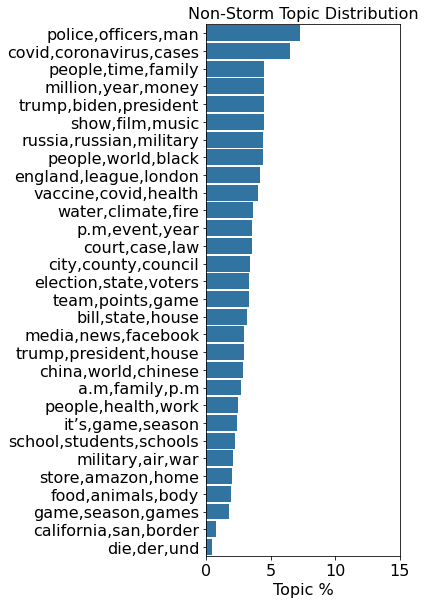

In [69]:
#try as seperate figures 
fig, ax = plt.subplots(1, figsize=(6, 8.5))
sns.barplot(x="amtNormed", y="firstWords",data=stormTopics, ax=ax, palette = [colDict["red"]], width=.9)
ax.set_xlim(0, 15)

#plt.suptitle("Topic Distributions: Storm vs. Non Storm Articles", fontsize=18)
ax.set_title("Storm Topic Distribution", fontsize=16)
ax.set_ylabel(None)
ax.tick_params(axis='y', which='major', labelsize=16)
ax.tick_params(axis='x', which='major', labelsize=16)
ax.set_xlabel("Topic %", fontsize=16)

plt.tight_layout()
plt.savefig(FIG_PATH + "stormTopicDist.pdf", bbox_inches = "tight")
#plt.tight_layout()

fig, ax = plt.subplots(1, figsize=(6, 8.5))
sns.barplot(x="amtNormed", y="firstWords",data=nonStormTopics, ax=ax, palette = [colDict["blue"]], width=.9)
ax.set_xlim(0, 15)

#plt.suptitle("Topic Distributions: Storm vs. Non Storm Articles", fontsize=18)
ax.set_title("Non-Storm Topic Distribution", fontsize=16)
ax.set_ylabel(None)
ax.tick_params(axis='y', which='major', labelsize=16)
ax.tick_params(axis='x', which='major', labelsize=16)
ax.set_xlabel("Topic %", fontsize=16)

plt.tight_layout()
plt.savefig(FIG_PATH + "nonStormTopicDist.pdf", bbox_inches = "tight")


In [70]:
FIG_PATH + "nonStormTopicDist.pdf"

'/home/blitt/projects/localNews/reports/figures/drafts/nonStormTopicDist.pdf'

In [15]:
bothTopics = pd.merge(stormTopics[["topicNum", "amtNormed", "firstWords"]].rename(columns={"amtNormed":"stormAmtNormed"}), \
                                                                             nonStormTopics[["topicNum", "amtNormed"]].rename(columns={"amtNormed":"nonStormAmtNormed"}), on="topicNum", how="inner")

In [16]:
bothTopics["diff"] = bothTopics["stormAmtNormed"] - bothTopics["nonStormAmtNormed"]
bothTopics = bothTopics.sort_values("diff", ascending=False)

In [17]:
bothTopics["pos"] = bothTopics["diff"] >= 0 

In [18]:
bothTopics

,topicNum,stormAmtNormed,firstWords,nonStormAmtNormed,diff,pos
0,11,13.752398,"court,case,law",3.529605,10.222793,True
2,1,11.843982,"bill,state,house",3.190029,8.653953,True
3,3,10.909449,"election,state,voters",3.330555,7.578894,True
4,19,9.674881,"trump,president,house",2.891656,6.783225,True
6,27,8.799370,"water,climate,fire",3.635249,5.164122,True
1,6,12.257144,"police,officers,man",7.245738,5.011407,True
5,13,9.246963,"trump,biden,president",4.470489,4.776474,True
8,2,5.631794,"vaccine,covid,health",4.045420,1.586374,True
9,26,3.428262,"media,news,facebook",2.944549,0.483713,True
7,0,6.000689,"covid,coronavirus,cases",6.482399,-0.481711,False


In [19]:
#start here

In [20]:
colDict

{'blue': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 'orange': (1.0, 0.4980392156862745, 0.054901960784313725),
 'green': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 'red': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 'purple': (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 'brown': (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 'pink': (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 'grey': (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 'yellow': (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 'turqoise': (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)}

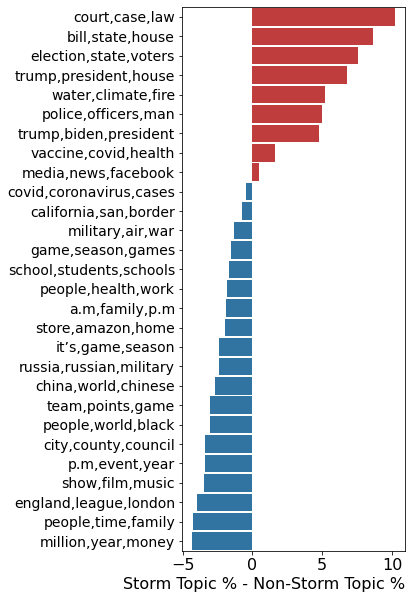

In [67]:

boolDict = {True:colDict["red"], False:colDict["blue"]}

fig, ax = plt.subplots(1, figsize=(4, 10))
plot = sns.barplot(x="diff", y="firstWords", palette= [boolDict[item] for item in bothTopics["pos"]] ,data=bothTopics, width=.9,ax=ax)
ax.set_ylabel(None)
ax.set_xlabel("Storm Topic % - Non-Storm Topic %",fontsize=16, loc="right")
#ax.set_title("Skew of Storm Coverage Topics", fontsize=14)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)
ax.set_xticks([-5.0, 0.0, 5.0, 10.0])
ax.set_xticklabels(ax.get_xticklabels(), fontsize=16)
#plt.tight_layout()

#for paper 
#plt.savefig(FIG_PATH + "stormTopicDiffs.pdf")

#for presentation
plt.savefig(FIG_PATH + "stormTopicDiffs.pdf", dpi=500, bbox_inches = "tight")

In [68]:
print(FIG_PATH + "stormTopicDiffs.pdf")

/home/blitt/projects/localNews/reports/figures/drafts/stormTopicDiffs.pdf
